In [30]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm

In [26]:
# Read data
df = pd.read_excel("./datasets/datasets.xlsx", sheet_name="Sheet1")

In [21]:
# Features and Targets
features = [
    'Tempmax_C', 'Tempmin_C', 'windspeedmax', 'windspeedmean',
    'solarradiation', 'uvindex', 'cloudcover', 'humidity', 'precip'
]
X = df[features]
y_wind = df['Wind_GWh']
y_solar = df['(Combined) Solar_GWh']
y_combined = df['(Combined) Renewable_Generation_GWh']

# Split all data at once to ensure alignment
X_train, X_test, y_train_wind, y_test_wind, y_train_solar, y_test_solar, y_train_combined, y_test_combined = train_test_split(
    X, y_wind, y_solar, y_combined, test_size=0.2, random_state=42
)

In [22]:
# First-level models (Wind & Solar)
model_wind = xgb.XGBRegressor(
    eta=0.31, 
    max_depth=4, 
    n_estimators=200, 
    gamma=49, 
    reg_lambda=1.02, 
    random_state=42
)
model_solar = xgb.XGBRegressor(
    eta=0.31, 
    max_depth=4, 
    n_estimators=200, 
    random_state=42
)

model_wind.fit(X_train, y_train_wind)
model_solar.fit(X_train, y_train_solar)

# First-level model predictions
pred_wind = model_wind.predict(X_test)
pred_solar = model_solar.predict(X_test)

In [23]:
# Build stacking features (first-level outputs as inputs)
stacked_X = np.column_stack([pred_wind, pred_solar])

# Second-level model (meta-regressor)
meta_model = xgb.XGBRegressor(
    eta=0.1352233009446337, 
    max_depth=2, 
    n_estimators=150, 
    random_state=42,
    colsample_bytree=0.8532241907732696,
    gamma=10,
    reg_lambda=0.8082370013955644,
    subsample=0.6976502088991097,
    tree_method='hist', 
    device='cuda'
)
meta_model.fit(stacked_X, y_test_combined)  # Note: using y_test_combined directly as target

# Predict combined output
y_pred_combined = meta_model.predict(stacked_X)

RMSE (XGB Stacked Combined): 2.134
R²   (XGB Stacked Combined): 0.947


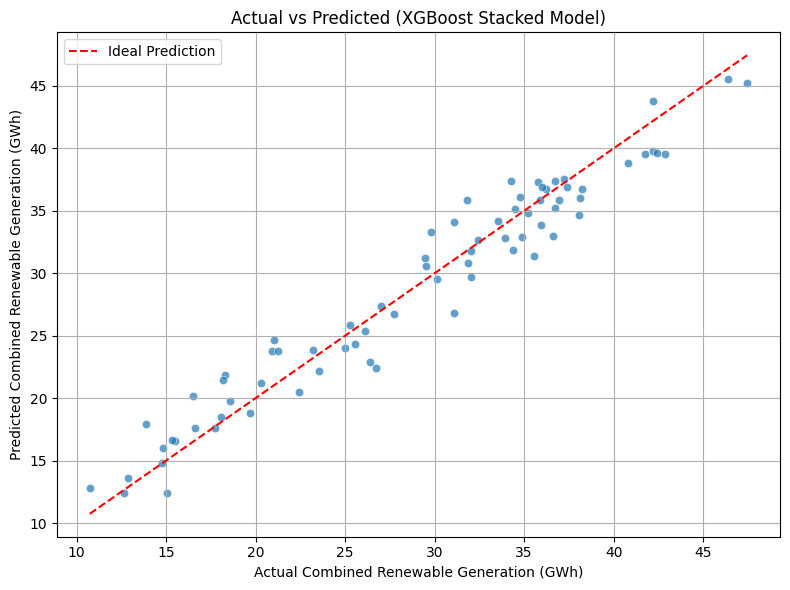

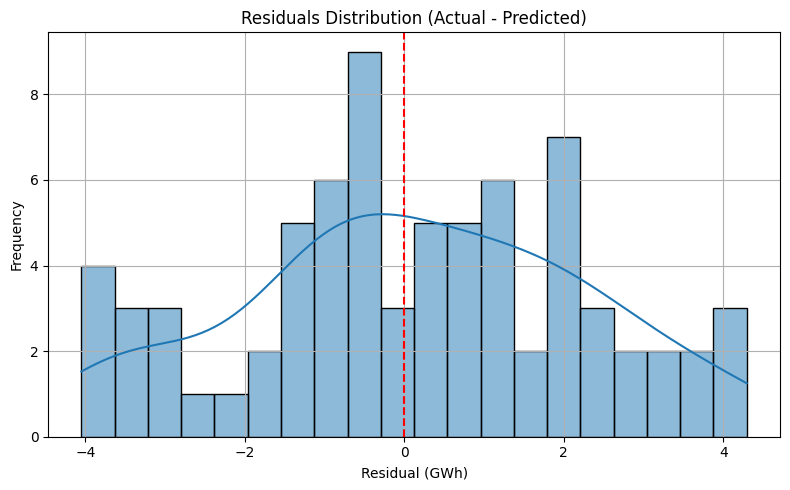

In [32]:
# Evaluation
rmse_stacked = np.sqrt(mean_squared_error(y_test_combined, y_pred_combined))
r2_stacked = r2_score(y_test_combined, y_pred_combined)

print(f"RMSE (XGB Stacked Combined): {rmse_stacked:.3f}")
print(f"R²   (XGB Stacked Combined): {r2_stacked:.3f}")

# Scatter plot: True vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_combined, y=y_pred_combined, alpha=0.7)
plt.plot([y_test_combined.min(), y_test_combined.max()],
         [y_test_combined.min(), y_test_combined.max()],
         color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel("Actual Combined Renewable Generation (GWh)")
plt.ylabel("Predicted Combined Renewable Generation (GWh)")
plt.title("Actual vs Predicted (XGBoost Stacked Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test_combined - y_pred_combined
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=20)
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution (Actual - Predicted)")
plt.xlabel("Residual (GWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


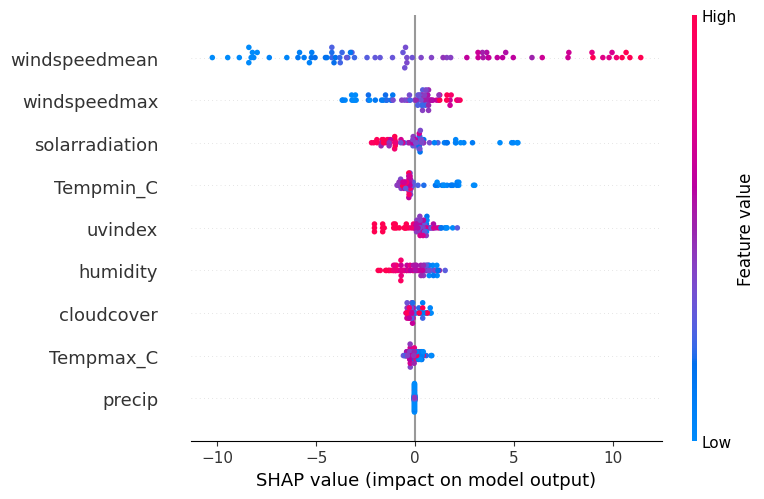

In [33]:
# Shap Value for Wind power model
explainer_wind = shap.Explainer(model_wind)
shap_values_wind = explainer_wind(X_test)

# SHAP Summary Plot - Wind
shap.summary_plot(shap_values_wind, X_test, show=True)

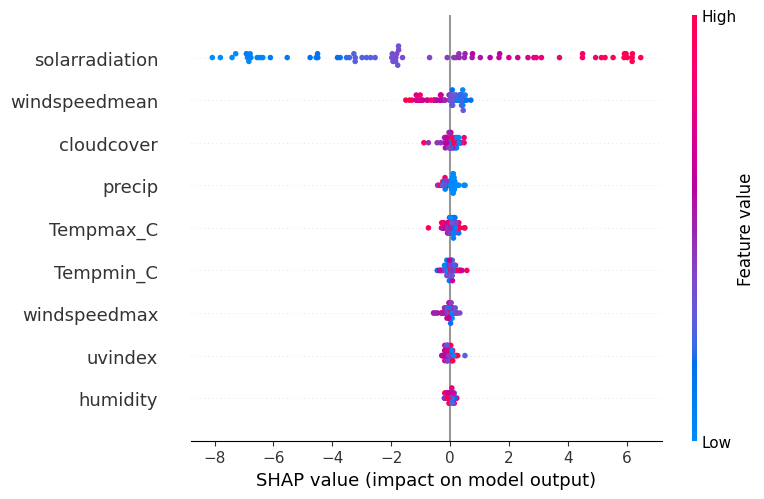

In [34]:
# Shap Value for Solar power model
explainer_solar = shap.Explainer(model_solar)
shap_values_solar = explainer_solar(X_test)

# SHAP Summary Plot - Solar
shap.summary_plot(shap_values_solar, X_test, show=True)